<a href="https://colab.research.google.com/github/MGrgat1/deep_learning_in_google_colab/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 1 - data loader

In [ ]:
# U ovom primjeru radit ćemo s MNIST setom podataka kako treniranje ne bi predugo trajalo
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Skinemo podatke MNIST dataseta kao u četvrtom predavanju
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)

# Koristimo dataloader za uzimanje podataka iz setova podataka:
# Označavamo veličinu batch_size-a i treba li podatke izmješati (shuffle)
# Batch size jednostavno mjenjamo kasnije ukoliko je kod dobro napisan!
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)
# Ispisuje sljedeće:
# torch.Size([64, 1, 28, 28])
# torch.Size([64])
# Zašto?
# Zato što imamo 64 slikice u batch-u, slika ima jedan kanal (Greyscale) i velika je 28 x 28 piksela
# Postoji jedan label za jednu sliku (kategoriju) i imamo 64 slike i samim time 64 kategorije

#Prikažimo slike... Onako usput.
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.title(str(labels.numpy()[index]))
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
plt.show()




# Example 2 - NN GPU

In [ ]:
# U ovom primjeru radit ćemo s MNIST setom podataka kako treniranje ne bi predugo trajalo
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image

cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Skinemo podatke MNIST dataseta kao u četvrtom predavanju
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)

# Koristimo dataloader za uzimanje podataka iz setova podataka:
# Označavamo veličinu batch_size-a i treba li podatke izmješati (shuffle)
# Batch size jednostavno mjenjamo kasnije ukoliko je kod dobro napisan!
# pin_memory znači loading u GPU. Neće raditi ako nema više workera!
train_loader = DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=1024, shuffle=True, num_workers=32, pin_memory=True)

# Kreiramo model:
# Ulaz je 784. Zašto? Zato što je 28 x 28 = 784
# Dakle, za svaki piksel imamo jedan ulaz u NN.
# Hidden veličine su nasumične
input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 10

# Prvo imamo linearni sloj, pa aktivaciju, pa linearni sloj itd...
# Na kraju dodajemo softmax koji se standardno koristi prilikom klasifikacije.
model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)




# Bilježimo početak
time0 = time()
# Idemo trenirati 15 epoha
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:

        # Sjetimo se što radi ova komanda!
        images = images.to(device).view(images.shape[0], -1)

        # Nuliramo gradijente
        optimizer.zero_grad()

        # Tražimo izlaz iz mreže i računamo grešku
        output = model(images)
        loss = loss_fn(output, labels.to(device))

        # Propagiramo grešku unazad
        loss.backward()

        # Idemo na idući korak
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(train_loader)))
print("\nTrenirali smo (u minutama):", (time() - time0) / 60)


# Example 3 - testing


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image

cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)


train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=True, num_workers=32, pin_memory=True)


input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 15

for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:

        images = images.to(device).view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(train_loader)))
print("\nTrenirali smo (u minutama):", (time() - time0) / 60)

# Poigrajte se samo s veličinom batch-a ;)
# Proučite kakav efekt ima veličina batch-size-a na treniranje!
# Krenite od: https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e
correct_count, all_count = 0, 0
for images, labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img.to(device))

        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if (true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Broj testiranih slika =", all_count)
print("\nTočnost modela =", (correct_count / all_count))

# Example 4 - storage GPU

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image

cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)


train_loader = DataLoader(trainset, batch_size=256, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=256, shuffle=True, num_workers=32, pin_memory=True)


input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 10


model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)


time0 = time()
epochs = 3
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:

        images = images.to(device).view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(train_loader)))
print("\nTrenirali smo (u minutama):", (time() - time0) / 60)

torch.save(model, 'models/moj_model_gpu.pth')

loaded_model = torch.load('models/moj_model_gpu.pth')
print(model)


torch.save(model.state_dict(), 'models/moj_model_gpu_stateovi.pth')

model_load = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1))

model_load.load_state_dict(torch.load('models/moj_model_gpu_stateovi.pth'))
model_load.to(device)

print(model_load)
# Dakle, pohrana je jako slična kada radimo s jednim GPU-om!
# U slučaju korištenja više GPU-ova, slučaj je malo drugačiji jer se koristi DataParallel model
# no to ćemo raditi na naprednim tehnikama treniranja.


# Example 5 - training with progress bar (tqdm)

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time, sleep

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
from tqdm import tqdm

cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

batch_size = 256

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)


input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 10


model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

epochs = 15
for e in range(epochs):
    # sjetimo se čemu služi enumerate!
    #Kreiramo petlju pomoću tqdm poziva. Kažemo mu ukupnu duljinu dataseta kako bi znao točno gdje smo.
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    #Sada tu imamo i index zbog enumerate
    for idx, (images, labels) in loop:

        images = images.to(device).view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        labels = labels.to(device)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        #Idemo odmah napraviti prikazivanje točnosti :)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = 100. * (correct / len(predictions))
        loop.set_description(f"Epoch [{e}/{epochs}")
        loop.set_postfix(loss = loss.item(), acc=accuracy)

# Example 6 - training with tensorboard

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time, sleep

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
import pkbar
from torch.utils.tensorboard import SummaryWriter


cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

batch_size = 256
#Inicijalizacija writera
writer = SummaryWriter('runs/MNIST')

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)


input_size = 784
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 10


model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

epochs = 15
train_per_epoch = int(len(trainset) / batch_size)
for e in range(epochs):
    kbar = pkbar.Kbar(target=train_per_epoch, epoch=e, num_epochs=epochs, width=20, always_stateful=False)
    for idx, (images, labels) in enumerate(train_loader):

        images = images.to(device).view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        labels = labels.to(device)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        writer.add_scalar('loss', loss.item(), (e * train_per_epoch) + idx)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / len(predictions)
        kbar.update(idx, values=[("loss", loss), ("acc", accuracy)])
        writer.add_scalar('acc', accuracy, (e * train_per_epoch) + idx)
        # Writer ima i funkcije za dodavanje ostalih tipova podataka. Slobodno ih istražite!


# LAB 4


```

# Installs

In [21]:
pip install pkbar

# Imports

# Training

Epoch: 1/15


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


121/121 [====================] - 36s 298ms/step - loss: 2.7324 - acc: 0.2640
Epoch: 2/15
121/121 [====================] - 36s 296ms/step - loss: 1.4781 - acc: 0.5672
Epoch: 3/15
121/121 [====================] - 36s 298ms/step - loss: 1.2291 - acc: 0.6388
Epoch: 4/15
121/121 [====================] - 37s 304ms/step - loss: 1.1266 - acc: 0.6704
Epoch: 5/15
121/121 [====================] - 37s 305ms/step - loss: 1.0460 - acc: 0.6950
Epoch: 6/15
121/121 [====================] - 36s 295ms/step - loss: 0.9686 - acc: 0.7176
Epoch: 7/15
121/121 [====================] - 36s 297ms/step - loss: 0.8948 - acc: 0.7391
Epoch: 8/15
121/121 [====================] - 36s 296ms/step - loss: 0.8248 - acc: 0.7598
Epoch: 9/15
121/121 [====================] - 36s 295ms/step - loss: 0.7675 - acc: 0.7761
Epoch: 10/15
121/121 [====================] - 36s 294ms/step - loss: 0.7162 - acc: 0.7900
Epoch: 11/15
121/121 [====================] - 36s 298ms/step - loss: 0.6740 - acc: 0.8039
Epoch: 12/15
121/121 [=========

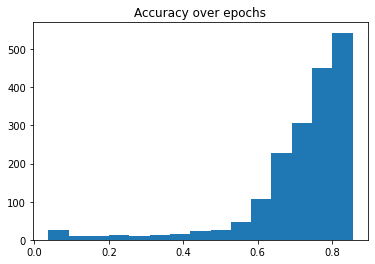

In [59]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time, sleep

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn, optim
from PIL import Image
import pkbar
from torch.utils.tensorboard import SummaryWriter


cuda = True if torch.cuda.is_available() else False
device = torch.device('cpu')
if cuda:
    device = torch.device('cuda')

batch_size = 256

#Inicijalizacija writera
writer = SummaryWriter('runs/EMNIST')

transforms = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transforms)
# testset = datasets.MNIST('mnist_data', download=True, train=False, transform=transforms)

## torchvision.datasets.EMNIST(root: str, split: str, **kwargs) → None
## root (string) – Root directory of dataset where EMNIST/processed/training.pt and EMNIST/processed/test.pt exist.
## split (string) – The dataset has 6 different splits: byclass, bymerge, balanced, letters, digits and mnist. This argument specifies which one to use.
## train (bool, optional) – If True, creates dataset from training.pt, otherwise from test.pt.
## download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

trainset = datasets.EMNIST('emnist_data', split='letters', download=True, train=True, transform=transforms)
testset = datasets.EMNIST('emnist_data', split='letters', download=True, train=False, transform=transforms)


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=32, pin_memory=True)


input_size = 784
hidden_size_1 = 64
hidden_size_2 = 64
output_size = 27


model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

epochs = 15
train_per_epoch = int(len(trainset) / batch_size)

epoch_measurements = []
accuracy_measurements = []
for e in range(epochs):
    kbar = pkbar.Kbar(target=train_per_epoch, epoch=e, num_epochs=epochs, width=20, always_stateful=False)
    for idx, (images, labels) in enumerate(train_loader):

        images = images.to(device).view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        labels = labels.to(device)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        writer.add_scalar('loss', loss.item(), (e * train_per_epoch) + idx)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / len(predictions)

        # data for the graph
        epoch_measurements.append(e)
        accuracy_measurements.append(accuracy)

        kbar.update(idx, values=[("loss", loss), ("acc", accuracy)])
        writer.add_scalar('acc', accuracy, (e * train_per_epoch) + idx)

plt.hist(accuracy_measurements, bins = 15)
plt.title('Accuracy over epochs')
plt.show()

# Testing

In [60]:
correct_count, all_count = 0, 0
for images, labels in test_loader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img.to(device))

        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if (true_label == pred_label):
            correct_count += 1
        all_count += 1

print("\nTest accuracy: ", (correct_count / all_count))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Test accuracy:  0.8301442307692307


# Result analysis

## Configuration 1

RELU

Hyperparameters:


batch_size = 256

input_size = 784

hidden_size_1 = 128

hidden_size_2 = 64

hidden_size_3 = 32

output_size = 27

model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, hidden_size_3),
                      nn.ReLU(),
                      nn.Linear(hidden_size_3, output_size),
                      nn.LogSoftmax(dim=1)).to(device)

loss_fn = nn.NLLLoss().to(device)

epochs = 15
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)


**Training runs:**
1. 

Training: 77ms/step - loss: 0.3994 - acc: 0.8757

Test accuracy: 0.8619230769230769

2. 
Epoch: 15/15

Training: 77ms/step - loss: 0.3878 - acc: 0.8796

Test accuracy: 0.8679807692307693

3.
Epoch: 15/15

Training: 74ms/step - loss: 0.3880 - acc: 0.8793

Test accuracy: 0.8739423076923077


## Configuration 2

Configuration 1, but this time Sigmoid instead of ReLU

model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size_2, hidden_size_3),
                      nn.Sigmoid(),
                      nn.Linear(hidden_size_3, output_size),
                      nn.LogSoftmax(dim=1)).to(device)

**Training runs:**

1.
Epoch: 15/15

Training: 78ms/step - loss: 3.2455 - acc: 0.1018

Test accuracy: 0.10788461538461538


## Configuration 3

Configuration 1, but this time all layers have double the amount of perceptrons

input_size = 784

hidden_size_1 = 256

hidden_size_2 = 128

hidden_size_3 = 64

output_size = 27


**Training runs:**
1. 
Training: 78ms/step - loss: 0.3290 - acc: 0.8971
Test accuracy: 0.886201923076923

2.
Training: 75ms/step - loss: 0.3318 - acc: 0.8957
Test accuracy: 0.8825480769230769

3.
Training: 77ms/step - loss: 0.3348 - acc: 0.8953
Test accuracy: 0.8834615384615384



## Configuration 4
Configuration 3, but this time with doubled learning rate

optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

**Training runs:**

1.
Training: 84ms/step - loss: 0.2384 - acc: 0.9209

Test accuracy: 0.90375

2.
Training: 79ms/step - loss: 0.2461 - acc: 0.9192

Test accuracy:  0.9

3.
Training: 81ms/step - loss: 0.2446 - acc: 0.9189

Test accuracy:  0.901298076923077

4.
Training: 82ms/step - loss: 0.2405 - acc: 0.9205

Test accuracy:  0.9037019230769231

## Configuration 5

A smaller network, with a faster learning rate

**A smaller network gets the same result as a larger network**

input_size = 784
hidden_size_1 = 64
hidden_size_2 = 64
output_size = 27


model = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1)).to(device)


loss_fn = nn.NLLLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

**Training runs:**

1.

Training: 79ms/step - loss: 0.3335 - acc: 0.8951

Test accuracy:  0.8801923076923077

2.

Training: 79ms/step - loss: 0.3303 - acc: 0.8947

Test accuracy:  0.8804807692307692

# Configuration 6

batch_size = 512

**Training runs:**

1.

Training: 147ms/step - loss: 0.4119 - acc: 0.8739

Test accuracy:  0.8646634615384615

## Configuration 7

batch_size = 1024

**Training runs:**

1.

Training: 304ms/step - loss: 0.5639 - acc: 0.8325

Test accuracy:  0.8301442307692307

# Storage

In [ ]:

torch.save(model, 'models/moj_model_gpu.pth')

loaded_model = torch.load('models/moj_model_gpu.pth')
print(model)


torch.save(model.state_dict(), 'models/moj_model_gpu_stateovi.pth')

model_load = nn.Sequential(nn.Linear(input_size, hidden_size_1),
                      nn.ReLU(),
                      nn.Linear(hidden_size_1, hidden_size_2),
                      nn.ReLU(),
                      nn.Linear(hidden_size_2, output_size),
                      nn.LogSoftmax(dim=1))

model_load.load_state_dict(torch.load('models/moj_model_gpu_stateovi.pth'))
model_load.to(device)

print(model_load)
# Dakle, pohrana je jako slična kada radimo s jednim GPU-om!
# U slučaju korištenja više GPU-ova, slučaj je malo drugačiji jer se koristi DataParallel model
# no to ćemo raditi na naprednim tehnikama treniranja.

FileNotFoundError: ignored